<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/main/CNN_from_SCRATCH_Version_Jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import os
import copy
import glob
import time
from pathlib import Path

import PIL
from PIL import Image


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [4]:


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)



Using PyTorch version: 1.10.0+cu111  Device: cuda


In [5]:
# Diverse Vorgaben zum Neuronalen Netz
#Number_Input_Neurons = 224*224    # Muss x Tensor Dimension entsprechen

Number_Hidden_Neurons = 50    # Je mehr, desto genauer (aber zu viel bringt nichts)
Number_Hidden_Neurons_1 = 80    # Je mehr, desto genauer (aber zu viel bringt nichts)
num_classes = 2    # Muss y Tensor Dimension entsprechen
BATCH_SIZE = 32
in_channels = 3
Learning_Rate = 0.01        # Muss individuell angepasst werden
Number_Epochs = 10         # Je höher, desto genauer

In [6]:


#New für Test
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/NN_SS2021/dogs-vs-cats.zip') as entire_zip:
     entire_zip.extractall('.')
with zipfile.ZipFile('./train.zip') as train_zip:
     train_zip.extractall('.')

train_dir = './train'



In [7]:


def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]



In [8]:
#New Datasets mit Label
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

In [9]:
class Dogs_CatsDataset(Dataset):

    def __init__(self, root, image_dir, csv_file, transform=None):
        self.root = root
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.data = pd.read_csv(csv_file).iloc[:, 1]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = os.path.join(self.image_dir, self.image_files[index])  
        image = PIL.Image.open(image_name)
        label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return (image, label)

In [10]:
Img_dir = glob.glob(os.path.join(train_dir, '*.jpg'))
x_train ,x_test = train_test_split(Img_dir,test_size=0.2,random_state=42)   #Image Split: Teilen 

In [11]:
image_dir = '/content/drive/MyDrive/NN_SS2021/dogs-vs-cats/train/train/'
csv_file = '/content/drive/MyDrive/NN_SS2021/dogs-vs-cats/train/dogs_cats.csv'

#transform_img = transforms.Compose([transforms.Resize((224,224)),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                               ])

# = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.RandomHorizontalFlip(),
#                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
#                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
#                               ])



#dset = Dogs_CatsDataset('/content/drive/MyDrive/Kaggle/dogs-vs-cats/train/train', image_dir, csv_file, transform= transform_img)
#print('Anzahl Daten: ',len(dset))

#train_dataset, validation_dataset = torch.utils.data.random_split(dset, [20000, 5000],generator=torch.Generator().manual_seed(42))
#print('Anzahl Train_Daten: ',len(train_dataset))
#print('Anzahl Test_Daten: ',len(validation_dataset))



transform_test = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

transform_Val = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

#new
x_train ,x_test = train_test_split(Img_dir,test_size=0.2)   #Image Split: Teilen 

train_dataset  = DogVsCatDataset(x_train, transform= transform_test)
validation_dataset = DogVsCatDataset(x_test, transform= transform_Val)

print('Anzahl Daten: ',len(Img_dir))
print('Anzahl Train_Daten: ',len(train_dataset))
print('Anzahl Test_Daten: ',len(validation_dataset))

Anzahl Daten:  25000
Anzahl Train_Daten:  20000
Anzahl Test_Daten:  5000


In [12]:


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Anzahl train_loader: ',len(train_loader))
print('Anzahl test_loader: ',len(validation_loader))



Anzahl train_loader:  625
Anzahl test_loader:  157


In [13]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in validation_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


In [14]:
classes = ('Cat', 'Dog')

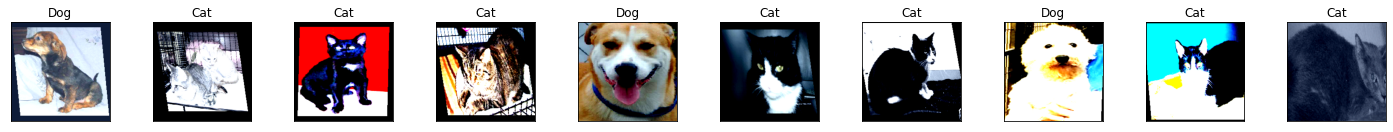

In [14]:
##### convert Tensor to image
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image


dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [15]:
class CNN_Modell(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(CNN_Modell, self).__init__()
        
       
        self.features = nn.Sequential(
            ##self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1, padding = 0)
            nn.Conv2d(in_channels, 6, kernel_size=5),
            ##nn.Tanh(),
            ##nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            

            nn.Conv2d(6, 10, kernel_size=5),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
           
            nn.Conv2d(10, 15, kernel_size=6),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
           
            nn.Conv2d(15, 20, kernel_size=9),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(20, 25, kernel_size=3),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
        )

        self.classifier = nn.Sequential(
            nn.Linear(3*3*25, Number_Hidden_Neurons),
            #nn.Tanh(),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(Number_Hidden_Neurons, Number_Hidden_Neurons_1),
            #nn.Tanh(),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(Number_Hidden_Neurons_1, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return probas

In [16]:


#Now
model_cnn = CNN_Modell(in_channels, num_classes).to(device)
model_cnn



CNN_Modell(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(10, 15, kernel_size=(6, 6), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(15, 20, kernel_size=(9, 9), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(20, 25, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=225, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(i

In [17]:
# Loss Function vorgeben 
criterion = nn.CrossEntropyLoss()  ## BCE

# Optimizer vorgeben (SGD Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr = Learning_Rate, momentum=0.9)
#optimizer = torch.optim.RMSprop(model_cnn.parameters(), lr = Learning_Rate)#, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

In [18]:
## train and validation function 

def train_val(epoch, train_loss_history,train_corrects_history,val_loss_history,val_corrects_history):
    train_loss = 0.0
    train_corrects = 0.0
    val_loss = 0.0
    val_corrects = 0.0


    since = time.time()
    best_acc = 0.0
    
    best_model_wts = copy.deepcopy(model_cnn.state_dict())
    # Set model to training mode
    model_cnn.train()
        
    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # Forward Propagation
        y_predicted = model_cnn(X_train)
      
        # Zero gradient buffers
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        _, preds = torch.max(y_predicted, 1)
        train_loss += loss.item()
        train_corrects += torch.sum(preds == y_train.data)
        
    else:
        # no need to build the computation graph for backprop when computing accuracy
        with torch.no_grad():
          for  X_val, y_val in validation_loader:
           

            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_outputs = model_cnn(X_val)

            val_loss = criterion(val_outputs, y_val)

            _, val_preds = torch.max(val_outputs, 1)
            val_loss += val_loss.item()
            val_corrects += torch.sum(val_preds == y_val.data)

        epoch_loss = train_loss/len(train_loader.dataset)
        epoch_acc = train_corrects.float()/ len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_corrects_history.append(epoch_acc)

        val_epoch_loss = val_loss/len(validation_loader.dataset)
        val_epoch_acc = val_corrects.float()/ len(validation_loader.dataset)

###############################
        if val_epoch_acc > best_acc:
          best_acc = val_epoch_acc
          best_model_wts = copy.deepcopy(model_cnn.state_dict())

##############################

        val_loss_history.append(val_epoch_loss)
        val_corrects_history.append(val_epoch_acc)
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item())) 

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model_cnn.load_state_dict(best_model_wts)

In [ ]:
####### Das ist jetzt die eigentliche Ausführung des Prozesses
## Train model
##%%time

train_loss_history = []
train_corrects_history = []
val_loss_history = []
val_corrects_history = []
#Number_Epochs=20
for epoch in range(Number_Epochs):
    train_val(epoch,train_loss_history,train_corrects_history,val_loss_history,val_corrects_history)

epoch : 1
training loss: 0.0217, acc 0.5008 
validation loss: 0.0003, validation acc 0.5104 
Training complete in 3m 52s
Best val Acc: 0.510400
epoch : 2
training loss: 0.0217, acc 0.5026 
validation loss: 0.0003, validation acc 0.5146 
Training complete in 3m 51s
Best val Acc: 0.514600


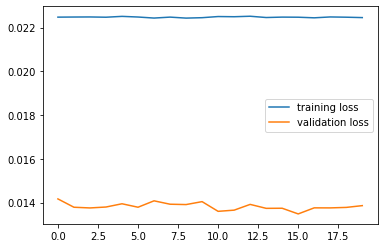

In [ ]:
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Dropout/Train_Val_Loss2.png')

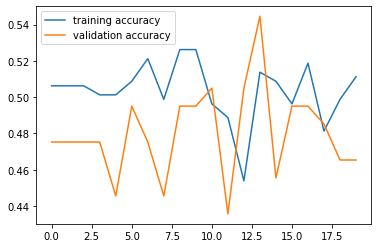

In [ ]:


plt.plot(train_corrects_history, label='training accuracy')
plt.plot(val_corrects_history, label='validation accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Dropout/Train_Val_Acc2.png')



In [ ]:
### copy model to drive
#import torch
model_save_name = 'Model_Cnn_Dogs_Cats2.pt'
path = F"/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Dropout/{model_save_name}" 
torch.save(model_cnn.state_dict(), path)

In [ ]:
from sklearn.metrics import confusion_matrix
#for i in range(len(validation_loader)-1):
x_test,y_test = next(iter(validation_loader))
y_pred = model_cnn(x_test.to(device))
y_test = y_test.to('cpu')
y=y_pred.data.max(1)[1].to('cpu')
Conf_Mat = confusion_matrix(y,y_test)
#print("Confusion Matrix : ")

for i in range(len(validation_loader)-1):
    x_test,y_test = next(iter(validation_loader))
    y_pred = model_cnn(x_test.to(device))
    y_test = y_test.to('cpu')
    y=y_pred.data.max(1)[1].to('cpu')
    Conf_Mat += confusion_matrix(y,y_test)
#print("Confusion Matrix : ")

Conf_Mat

array([[ 7,  2],
       [69, 50]])

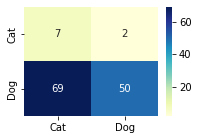

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(Conf_Mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (3,2))
sn.heatmap(df_cm,cmap="YlGnBu",annot=True)#,fmt='.2%')
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Dropout/Train_Val_Conf2.png')

In [16]:
class CNN_Modell2(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(CNN_Modell2, self).__init__()
        
       
        self.features = nn.Sequential(
            ##self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1, padding = 0)
            nn.Conv2d(in_channels, 6, kernel_size=5),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            

            nn.Conv2d(6, 10, kernel_size=5),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
           
            nn.Conv2d(10, 15, kernel_size=6),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
           
            nn.Conv2d(15, 20, kernel_size=9),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(20, 25, kernel_size=3),
            #nn.Tanh(),
            #nn.AvgPool2d(kernel_size = 2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
        )

        self.classifier = nn.Sequential(
            nn.Linear(3*3*25, Number_Hidden_Neurons),
            #nn.Tanh(),
            nn.ReLU(),
            nn.Linear(Number_Hidden_Neurons, Number_Hidden_Neurons_1),
            #nn.Tanh(),
            nn.ReLU(),
            nn.Linear(Number_Hidden_Neurons_1, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return probas

In [19]:
#Now
model_cnn2 = CNN_Modell2(in_channels, num_classes).to(device)
model_cnn2

CNN_Modell2(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(10, 15, kernel_size=(6, 6), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(15, 20, kernel_size=(9, 9), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(20, 25, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=225, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=80, bias=T

In [21]:
# Loss Function vorgeben 
criterion = nn.CrossEntropyLoss()  ## BCE
# Optimizer vorgeben (SGD Stochastic Gradient Descent)
Learning_Rate = 0.1
optimizer = torch.optim.SGD(model_cnn2.parameters(), lr = Learning_Rate, momentum=0.9)

In [22]:
def train_val(epoch, train_loss_history,train_corrects_history,val_loss_history,val_corrects_history):
    train_loss = 0.0
    train_corrects = 0.0
    val_loss = 0.0
    val_corrects = 0.0

    since = time.time()
    best_acc = 0.0
    
    best_model_wts = copy.deepcopy(model_cnn2.state_dict())
    # Set model to training mode
    model_cnn2.train()
        
    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # Forward Propagation
        y_predicted = model_cnn2(X_train)
      
        # Zero gradient buffers
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        _, preds = torch.max(y_predicted, 1)
        train_loss += loss.item()
        train_corrects += torch.sum(preds == y_train.data)
        
    else:
        # no need to build the computation graph for backprop when computing accuracy
        with torch.no_grad():
          for  X_val, y_val in validation_loader:
           

            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_outputs = model_cnn2(X_val)

            val_loss = criterion(val_outputs, y_val)

            _, val_preds = torch.max(val_outputs, 1)
            val_loss += val_loss.item()
            val_corrects += torch.sum(val_preds == y_val.data)

        epoch_loss = train_loss/len(train_loader.dataset)
        epoch_acc = train_corrects.float()/ len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_corrects_history.append(epoch_acc)

        val_epoch_loss = val_loss/len(validation_loader.dataset)
        val_epoch_acc = val_corrects.float()/ len(validation_loader.dataset)

###############################
        if val_epoch_acc > best_acc:
          best_acc = val_epoch_acc
          best_model_wts = copy.deepcopy(model_cnn2.state_dict())

##############################

        val_loss_history.append(val_epoch_loss)
        val_corrects_history.append(val_epoch_acc)
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model_cnn2.load_state_dict(best_model_wts) 

In [23]:
####### Das ist jetzt die eigentliche Ausführung des Prozesses
## Train model
##%%time

train_loss_history2 = []
train_corrects_history2 = []
val_loss_history2 = []
val_corrects_history2 = []
#Number_Epochs=20
for epoch in range(Number_Epochs):
    train_val(epoch,train_loss_history2,train_corrects_history2,val_loss_history2,val_corrects_history2)

epoch : 1
training loss: 0.0225, acc 0.5287 
validation loss: 0.0135, validation acc 0.3861 
Training complete in 0m 13s
Best val Acc: 0.386139
epoch : 2
training loss: 0.0224, acc 0.5287 
validation loss: 0.0136, validation acc 0.3861 
Training complete in 0m 12s
Best val Acc: 0.386139
epoch : 3
training loss: 0.0224, acc 0.5287 
validation loss: 0.0136, validation acc 0.3861 
Training complete in 0m 12s
Best val Acc: 0.386139
epoch : 4
training loss: 0.0225, acc 0.5287 
validation loss: 0.0135, validation acc 0.3861 
Training complete in 0m 12s
Best val Acc: 0.386139
epoch : 5
training loss: 0.0224, acc 0.5287 
validation loss: 0.0136, validation acc 0.3861 
Training complete in 0m 12s
Best val Acc: 0.386139
epoch : 6
training loss: 0.0225, acc 0.5287 
validation loss: 0.0134, validation acc 0.3861 
Training complete in 0m 12s
Best val Acc: 0.386139
epoch : 7
training loss: 0.0224, acc 0.5287 
validation loss: 0.0136, validation acc 0.3861 
Training complete in 0m 12s
Best val Acc: 0

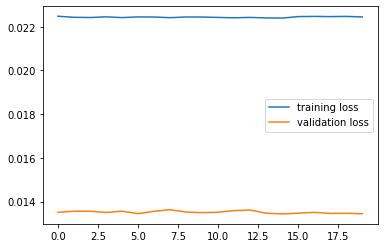

In [24]:
plt.plot(train_loss_history2, label='training loss')
plt.plot(val_loss_history2, label='validation loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Lr0.1/Train_Val_Loss2.png')

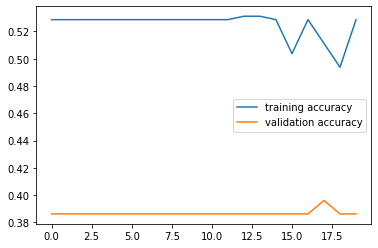

In [27]:
plt.plot(train_corrects_history2, label='training accuracy')
plt.plot(val_corrects_history2, label='validation accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Lr0.1/Train_Val_Acc2.png')

In [28]:
from sklearn.metrics import confusion_matrix

x_test2,y_test2 = next(iter(validation_loader))
y_pred2 = model_cnn2(x_test2.to(device))
y_test2 = y_test2.to('cpu')
y2=y_pred2.data.max(1)[1].to('cpu')
Conf_Mat2 = confusion_matrix(y2,y_test2)


for i in range(len(validation_loader)-1):
    x_test2,y_test2 = next(iter(validation_loader))
    y_pred2 = model_cnn2(x_test.to(device))
    y_test2 = y_test2.to('cpu')
    y2=y_pred2.data.max(1)[1].to('cpu')
    Conf_Mat2 += confusion_matrix(y2,y_test2)
#print("Confusion Matrix : ")
Conf_Mat2

AttributeError: ignored

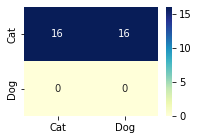

In [29]:
import seaborn as sn
df_cm = pd.DataFrame(Conf_Mat2, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (3,2))
sn.heatmap(df_cm,cmap="YlGnBu",annot=True)#,fmt='')
plt.savefig('/content/drive/MyDrive/NN_SS2021/CNN_Model_mit_Lr0.1/Train_Val_Conf2.png')